In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [39]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 13.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels import graphics
import statsmodels.api as sm

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler


plt.rcParams['figure.figsize'] = (16, 9)
style.use('ggplot')

In [4]:
working_dir = '/content/drive/MyDrive/Apziva/Value Investor/'

In [5]:
excel_sheets = pd.read_excel(working_dir + 'dataset.xlsx', 
                       sheet_name = None, 
                       parse_dates=['Date'], 
                       index_col = 'Date', 
                       skipfooter=1)

In [6]:
#df

In [7]:
print(f'Excel contains {len(excel_sheets.keys())} sheets')
print(f'The First sheet is named: {list(excel_sheets.keys())[0]}')

Excel contains 8 sheets
The First sheet is named: Russia - Sberbank Rossii PAO (S


# Russia Sberbank 

In [8]:
df = excel_sheets[list(excel_sheets.keys())[0]]


df.head(), df.tail()

(             Price    Open    High     Low    Vol.  Change %
 Date                                                        
 2021-03-31  291.02  294.00  294.42  290.26  47.00M   -0.0076
 2021-03-30  293.25  294.86  295.72  291.50  38.81M   -0.0002
 2021-03-29  293.30  289.72  294.09  289.26  43.68M    0.0071
 2021-03-26  291.22  288.63  292.75  288.32  56.07M    0.0159
 2021-03-25  286.66  286.50  287.03  283.85  35.22M    0.0030,
              Price    Open    High     Low    Vol.  Change %
 Date                                                        
 2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
 2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
 2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
 2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
 2020-01-03  255.00  255.99  258.19  253.70  35.85M    0.0010)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2021-03-31 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.0+ KB


In [10]:
df.shape

(311, 6)

# EDA and Data Cleaning

Investigate Volume Column.

This column is a combination of digits of number and a char detailing the volume of the trade.

M = millions
K = thousands
`-` = no trade

In [11]:
for key in excel_sheets.keys():
  print(excel_sheets[key]['Vol.'].str[-1].unique())

['M']
['M']
['M' 'K']
['M']
['K' 'M']
['K' 'M']
['M' 'K']
['K' 'M' '-']


In [12]:
def volume_to_int(volume):
    if volume[-1]=='M':
        return float(volume[:-1])*1000000
    elif volume[-1]=='K':
        return float(volume[:-1])*1000
    else:
        return 0

In [13]:
for key in excel_sheets.keys():
  temp = excel_sheets[key]

  temp['Vol.'] = temp['Vol.'].apply(volume_to_int)
  
  temp['Change'] = temp['Change %']*100
    
  #sort the index (dates)
  temp.sort_index(inplace = True)

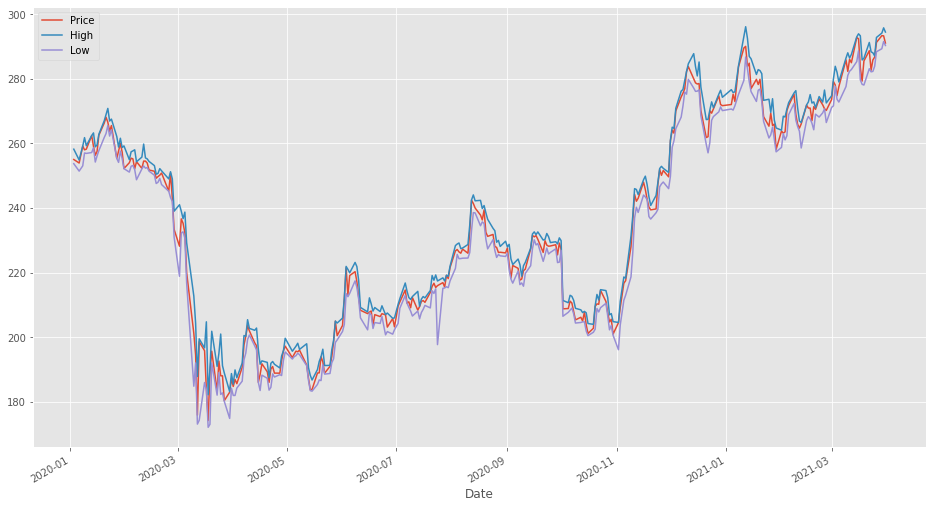

In [15]:
df[['Price','High', 'Low']].plot()
plt.show()

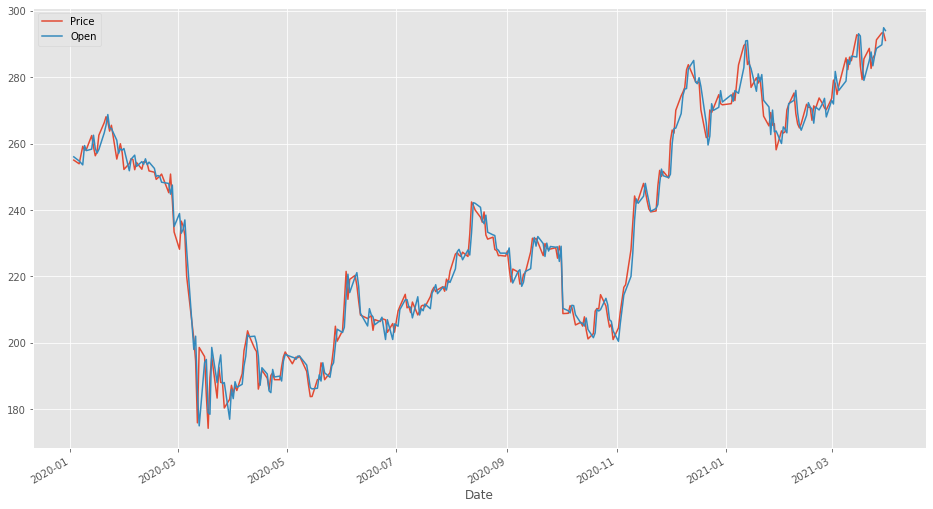

In [16]:
df[['Price','Open']].plot()


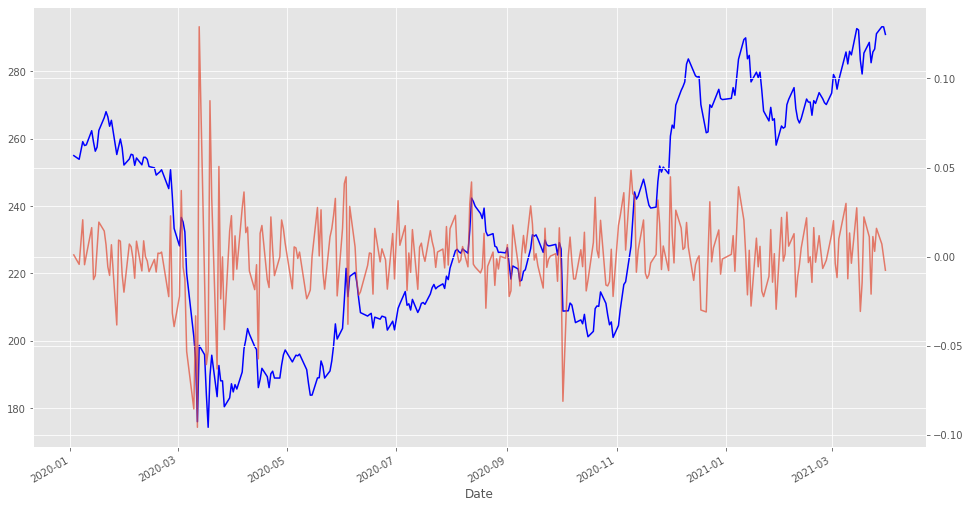

In [17]:
fig, ax1 = plt.subplots()
df['Price'].plot(ax = ax1, color = 'blue')

ax2 = ax1.twinx()
df['Change %'].plot(ax = ax2, alpha = 0.7)

# Scaling using MinMaxScaler (because of different price ranges)

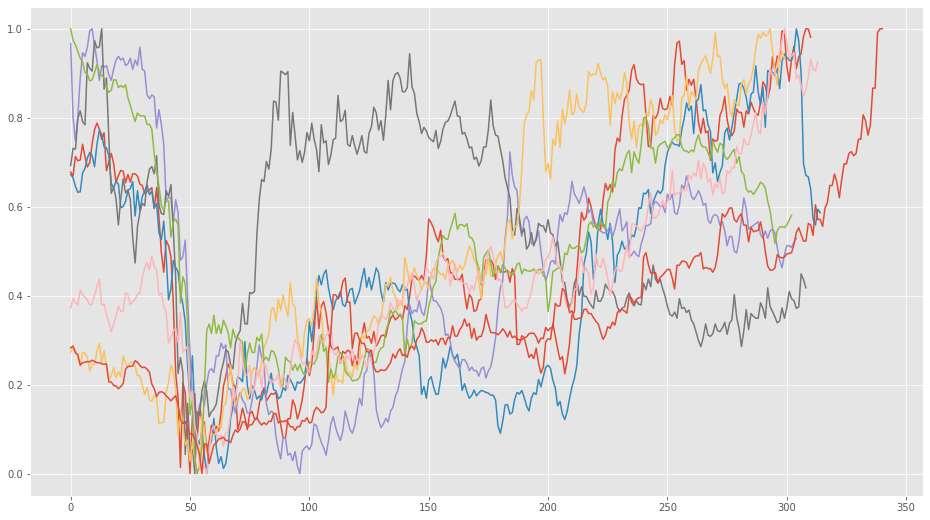

In [18]:
for k in excel_sheets.keys():
    scaler = MinMaxScaler()
    y_t = scaler.fit_transform(np.array(excel_sheets[k][['Price']]))
    plt.plot(y_t)

plt.show()

## Check Time Series frequency

In [19]:
print(f'Frequency of the Time Series: {df.index.freq}')

Frequency of the Time Series: None


In [20]:
# B = business days 
df2 = df.resample('B').mean()


print(df2.isna().sum())

Price       14
Open        14
High        14
Low         14
Vol.        14
Change %    14
Change      14
dtype: int64


In [21]:
df2[df2['Price'].isna()]

,Price,Open,High,Low,Vol.,Change %,Change
Date,,,,,,,
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df2.fillna(method = 'ffill', inplace = True)

In [23]:
df2

,Price,Open,High,Low,Vol.,Change %,Change
Date,,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010,0.10
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043,-0.43
2020-01-07,253.90,254.75,254.84,251.40,22350000.0,-0.0043,-0.43
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207,2.07
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045,-0.45
...,...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030,0.30
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159,1.59
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071,0.71


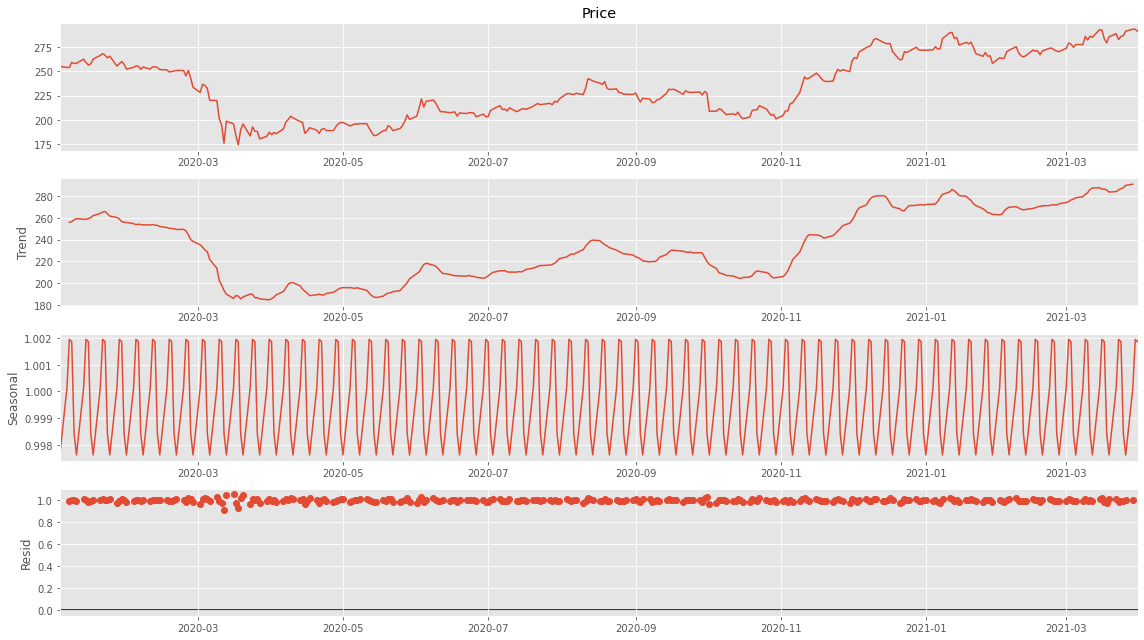

In [24]:
decomposition = seasonal_decompose(df2['Price'], model='multiplicative')
decomposition.plot()
plt.show()

In [25]:
def tsplot(y, lags=None, figsize=(12, 7)):
    # Modified from from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
    """
        Plot the time series, its ACF and PACF, and calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    
#tsplot(daily_sales_ds['Daily Sales'])

In [26]:
y = df2['Price']

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


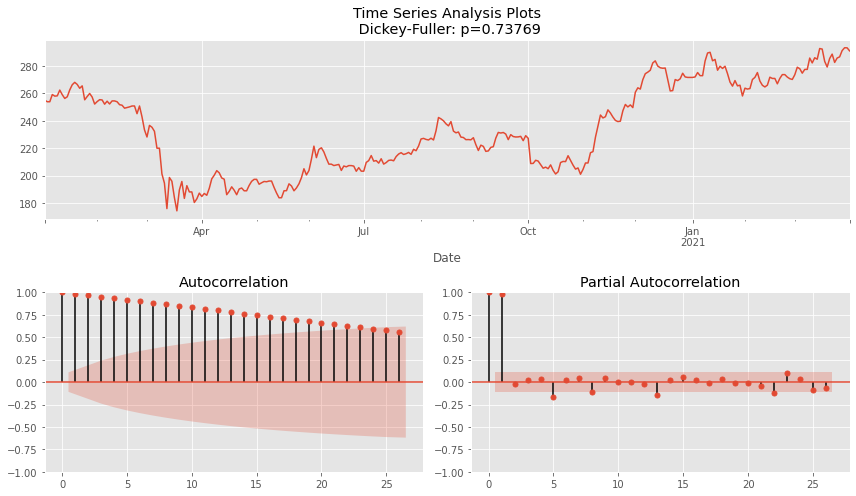

In [27]:
tsplot(y)

Data is not stationary

Do a differencing 

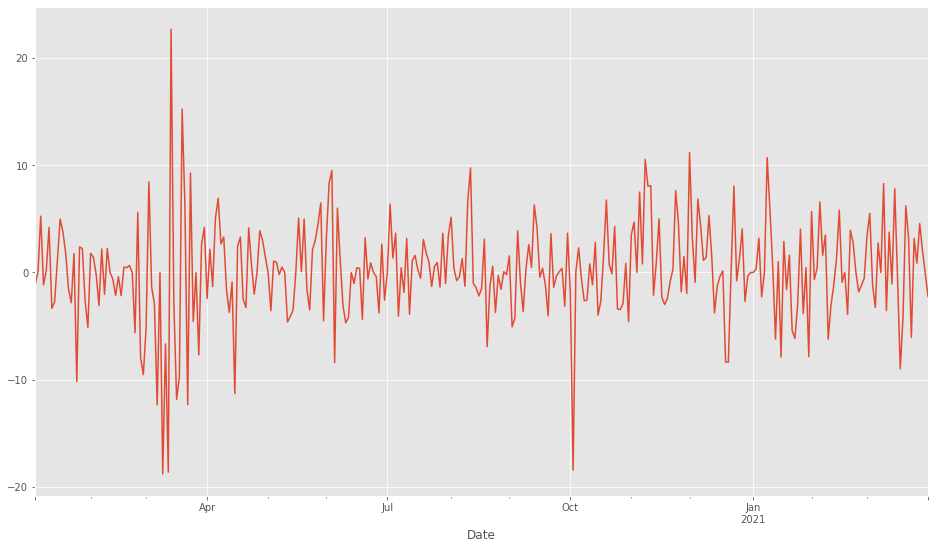

In [28]:
y_d = y.diff().dropna()
y_d.plot()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


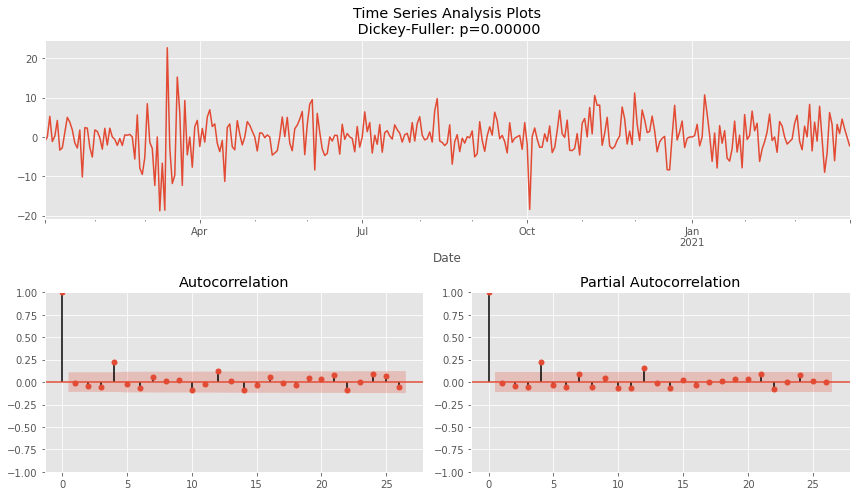

In [29]:
tsplot(y_d)

Now it is stationary

In [30]:
train_len = (y.index.year==2020).sum()
y_train = y[:train_len]
y_test = y[train_len:]


train_len_d = (y_d.index.year==2020).sum()
y_d_train = y_d[:train_len_d]
y_d_test = y_d[train_len_d:]

In [31]:
pdq_arima = auto_arima(y_d_train, trace = True)
p,d,q = pdq_arima.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1543.551, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1549.508, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1551.507, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1551.507, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1547.554, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1555.226, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1555.093, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1542.192, Time=0.56 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1554.075, Time=0.37 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1543.632, Time=0.28 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1543.965, Time=0.74 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1543.088, Time=0.50 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1543.543, Time=0.28 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=1544.251, Time=1.02 sec
 ARIMA(3,0,2)(0,0,0)[0]          

In [32]:
total_len = y.shape[0]

model = SARIMAX(y_train, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model=model.fit()
y_pred = model.predict(start = train_len, end = total_len-1)
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  260
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 5)   Log Likelihood                -762.726
Date:                           Sat, 21 Jan 2023   AIC                           1547.453
Time:                                   08:59:16   BIC                           1586.364
Sample:                               01-03-2020   HQIC                          1563.106
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1159      0.408      2.732      0.006       0.315       1.916
ar.L2         -0.3795      0.404     -0.938      0.348      -1.172       0.413
ar.L3          0.1194      0.063      1.887      0.059      -0.005       0.243
ma.L1         -1.1173      0.405     -2.756      0.006      -1.912      -0.323
ma.L2          0.3538      0.401      0.883      0.377      -0.431       1.139
ar.S.L5       -0.9857      0.769     -1.282      0.200      -2.493       0.522
ar.S.L10      -0.2689      0.144     -1.866      0.062      -0.551       0.013
ar.S.L15      -0.1396      0.099     -1.410      0.159      -0.334       0.054
ma.S.L5       -0.1517      0.780     -0.195      0.846      -1.680       1.377
ma.S.L10      -0.8330      0.773     -1.077      0.281      -2.349       0.682
sigma2        21.9909      3.488      6.304      0.000      15.154      28.828
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               168.02
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AttributeError: ignored

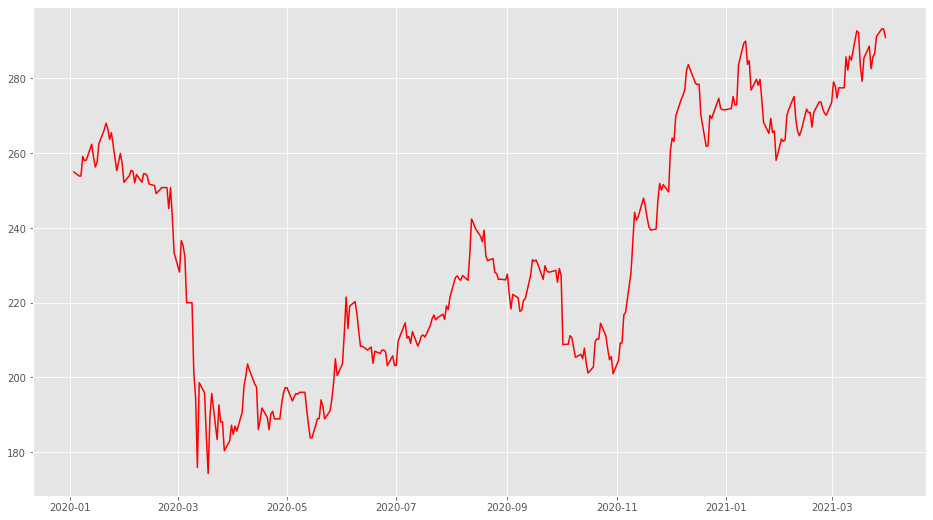

In [68]:

plt.plot(y, color = 'r', label = 'Provided Data')
plt.plot(model.predict(), color = 'b', label = 'Predicted Train Set')

y_pred.index = y_test.index

plt.plot(y_pred, color = 'g', label = 'Predicted Test Set')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.title('Stock price')
plt.legend()
plt.show()


https://tcoil.info/compute-bollinger-bands-for-stocks-with-python-and-pandas/

https://medium.com/codex/algorithmic-trading-with-bollinger-bands-in-python-1b0a00c9ef99

In [69]:
def bollinger_bands(df, n):
    # takes dataframe on input
    # n = smoothing length
    
    df['mov_avg'] = df['predicted'].rolling(n).mean()
    df['mov_std'] = df['predicted'].rolling(n).std()
    df['upper'] = df['mov_avg'] + 2*df['mov_std']
    df['lower'] = df['mov_avg'] - 2*df['mov_std']
    df.dropna(inplace = True)
    return df

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

def plot_bollinger(df, buy_price, sell_price):
    df['predicted'].plot(label = 'Predicted Price', alpha = 0.3, color = 'blue')
    df['test_set'].plot(label = 'Actual Price', alpha = 0.3, color = 'red')
    df['upper'].plot(label = 'Upper BB', linestyle = '--', linewidth = 1, color = 'black')
    df['mov_avg'].plot(label = 'Middle BB', linestyle = '--', linewidth = 1.2, color = 'grey')
    df['lower'].plot(label = 'Lower BB', linestyle = '--', linewidth = 1, color = 'black')
    plt.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    plt.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.title('Bollinger Band Strategy Trading Signals')
    plt.legend(loc = 'upper left')
    plt.show()

    
def calculate_return(buy_price, sell_price, y_test):
    i = 0
    result =0
    bp = None
    initial = None
    while i < len(buy_price) and math.isnan(buy_price[i]):
        i+=1
    if i < len(buy_price) and buy_price[i]>0:
        initial = buy_price[i]
    while i < len(buy_price):
        if buy_price[i]>0:
            bp = buy_price[i]
        elif sell_price[i]>0:
            if bp:
                result += (sell_price[i]-bp)
                bp = None
        i+=1
    if initial:
        result = (result/initial)*100
    do_nothing = (y_test[-1]/y_test[0] -1)*100
    print(f'Return using Bollinger Band Strategy is {round(result,2)}%.\nReturn from do nothing strategy is {round(do_nothing,2)}%')

In [70]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 20)


In [71]:
df_pred

,test_set,predicted,mov_avg,mov_std,upper,lower
Date,,,,,,
2021-01-28,265.960,274.470853,274.002174,0.711598,275.425369,272.578979
2021-01-29,258.110,274.249682,274.077761,0.647659,275.373079,272.782442
2021-02-01,263.800,274.361792,274.110563,0.644432,275.399426,272.821699
2021-02-02,263.150,275.071487,274.119440,0.656893,275.433226,272.805653
2021-02-03,263.530,275.799970,274.173940,0.747442,275.668824,272.679056
2021-02-04,270.110,275.014722,274.231280,0.766476,275.764232,272.698329
2021-02-05,271.700,274.772301,274.306903,0.739732,275.786367,272.827440
2021-02-08,275.200,274.922179,274.416170,0.651780,275.719731,273.112610
2021-02-09,268.980,275.568711,274.501764,0.685968,275.873701,273.129827


/usr/local/lib/python3.8/dist-packages/numpy/lib/shape_base.py:652: UserWarning: Warning: converting a masked element to nan.
  arr = asanyarray(v)


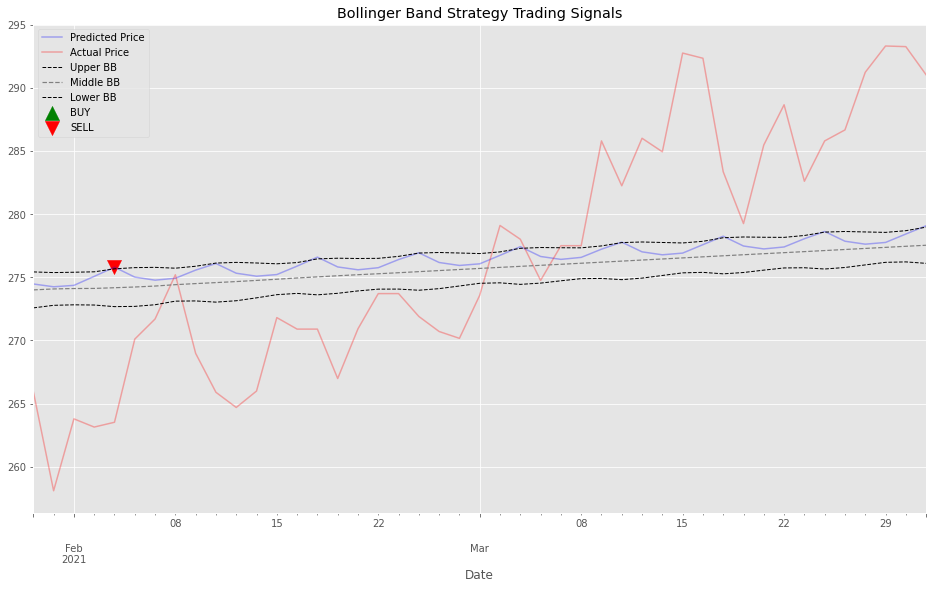

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 7.13%


In [72]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['predicted'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

/usr/local/lib/python3.8/dist-packages/numpy/lib/shape_base.py:652: UserWarning: Warning: converting a masked element to nan.
  arr = asanyarray(v)


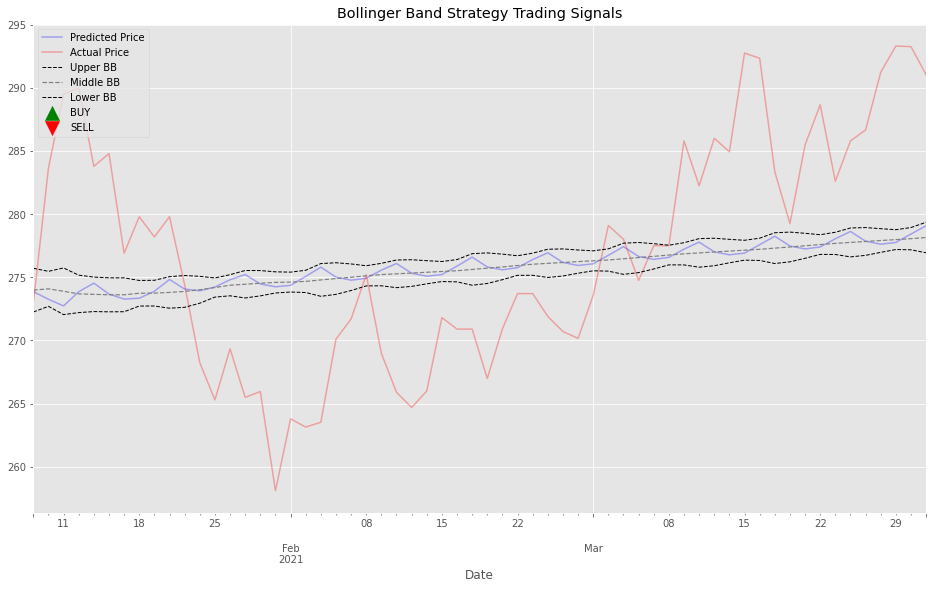

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 7.13%


In [73]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['predicted'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

This is BB strategy on predicted data after 2021

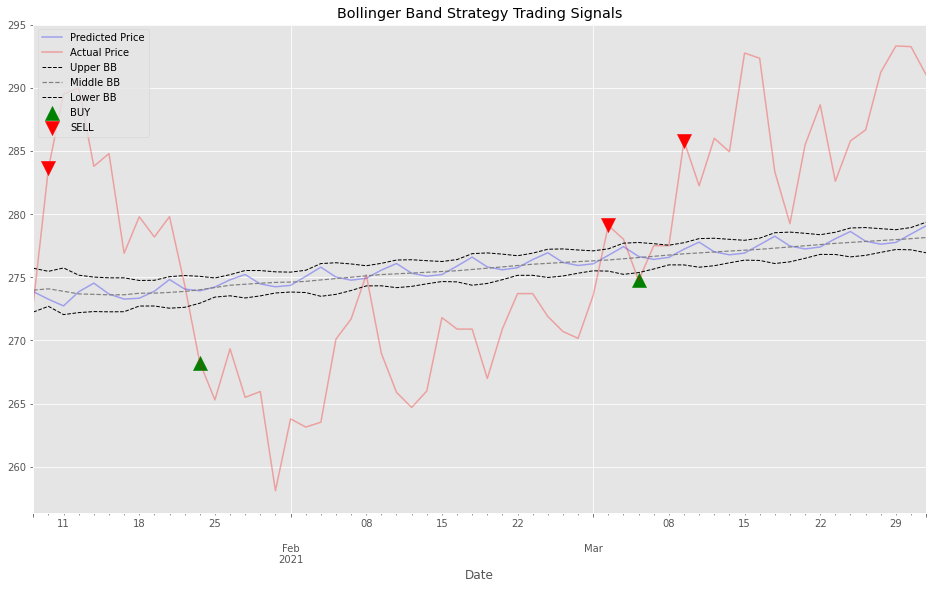

Return using Bollinger Band Strategy is 8.16%.
Return from do nothing strategy is 7.13%


In [74]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

This is BB strategy on the actual price

In [75]:
# GARCH Model

In [76]:
from arch import arch_model
from arch.__future__ import reindexing

garch_model = arch_model(y_train, p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

mu          210.834680
omega         6.225940
alpha[1]      0.857323
beta[1]       0.142677
Name: params, dtype: float64


                    h.1          h.2          h.3          h.4          h.5
Date                                                                       
2020-12-31  3707.397277  3713.623218  3719.849158  3726.075098  3732.301038


In [77]:
y_test

Date
2021-01-01    271.65
2021-01-04    272.00
2021-01-05    275.20
2021-01-06    272.93
2021-01-07    272.93
               ...  
2021-03-25    286.66
2021-03-26    291.22
2021-03-29    293.30
2021-03-30    293.25
2021-03-31    291.02
Freq: B, Name: Price, Length: 64, dtype: float64

In [78]:
print(len(y_test))

64


/usr/local/lib/python3.8/dist-packages/arch/univariate/volatility.py:1189: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Text(0.5, 1.0, 'Rolling Prediction')

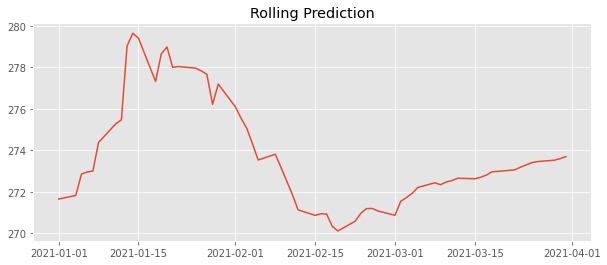

In [87]:
rolling_predictions = []
test_size = len(y_test)

for i in range(test_size):
    train = y_test[:i+1]
    #print(train)
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    # print(pred)
    # break
    #rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    rolling_predictions.append(pred.mean.values[0][0])
    
rolling_predictions = pd.Series(rolling_predictions, index=y_test.index)

fig,ax = plt.subplots(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

In [88]:
rolling_predictions

Date
2021-01-01    271.650000
2021-01-04    271.825000
2021-01-05    272.857601
2021-01-06    272.953953
2021-01-07    273.001760
                 ...    
2021-03-25    273.408221
2021-03-26    273.458227
2021-03-29    273.525867
2021-03-30    273.604751
2021-03-31    273.698145
Freq: B, Length: 64, dtype: float64

In [89]:
type(rolling_predictions)

pandas.core.series.Series

In [90]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':rolling_predictions})
df_pred = bollinger_bands(df_pred, 5)



In [91]:
df_pred

,test_set,predicted,mov_avg,mov_std,upper,lower
Date,,,,,,
2021-01-07,272.930,273.001760,272.457663,0.662359,273.782381,271.132945
2021-01-08,283.640,274.382723,273.004207,0.910338,274.824884,271.183531
2021-01-11,289.490,275.276016,273.694411,1.084383,275.863176,271.525645
2021-01-12,289.990,275.472709,274.217432,1.203939,276.625311,271.809554
2021-01-13,283.780,279.031739,275.432990,2.235574,279.904137,270.961842
2021-01-14,284.790,279.649600,276.762558,2.399027,281.560612,271.964503
2021-01-15,276.900,279.408764,277.767766,2.197038,282.161842,273.373690
2021-01-18,279.790,277.323528,278.177268,1.764793,281.706854,274.647683
2021-01-19,278.190,278.654200,278.813566,0.914662,280.642890,276.984243


/usr/local/lib/python3.8/dist-packages/numpy/lib/shape_base.py:652: UserWarning: Warning: converting a masked element to nan.
  arr = asanyarray(v)


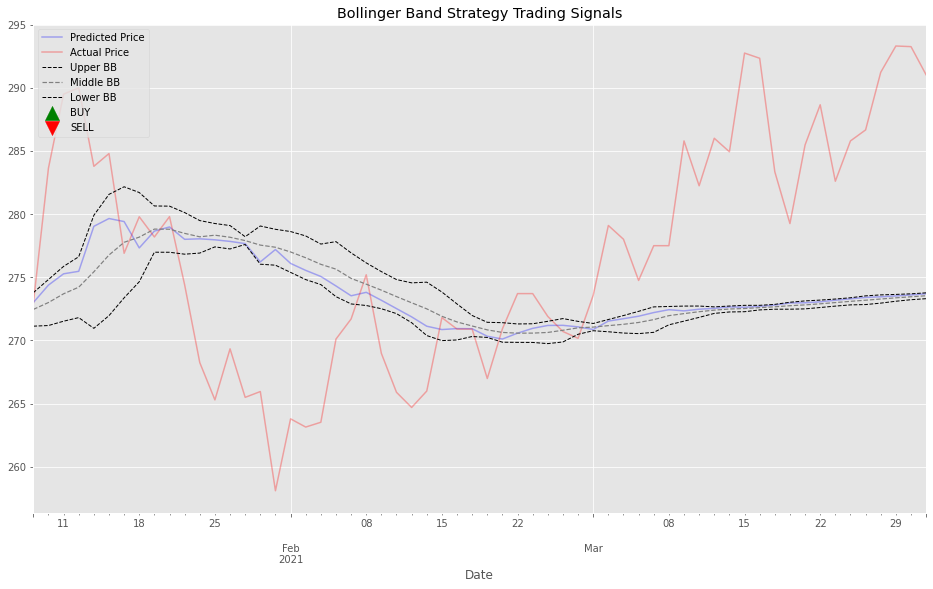

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 7.13%


In [92]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['predicted'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)